![Curso de Visión Artificial](imagenes/encabezado.png)




# Métodos de Segmentación

En Visión Artificial la segmentación consiste en el proceso de dividir una imagen en partes o grupos de píxeles que representan los diferentes objetos en la escena. En este sentido, la segmentación busca simplificar la representación de la imagen para facilitar su análisis. 

En general, los algoritmos de segmentación o bien buscan las discontinuidades en la imagen (representadas por puntos, líneas o bordes) o agrupan los píxeles que tienen cierta similitud. 

Veamos como usar diferentes métodos de segmentacióna en `Skimage`.

In [1]:
# Siempre que usemos matplotlib en Jupyter es necesario poner esta línea antes de cualquier otra
%matplotlib inline

# Importamos las bibliotecas necesarias y les asigamos un alias
import skimage                           # Biblioteca para la manipulación de imágenes
import numpy as np                       # Biblioteca para la manipulación de matrices

# Importamos algunos paquetes específicos
from matplotlib import pyplot as plt     # Biblioteca para crear graficas y mostrar las imágenes en pantalla

from skimage import data                 # Paquete con imágenes de prueba
from skimage import io                   # Paquete para lectura/escritura de imágenes
from skimage import color                # Paquete con las operaciones de transformaciones entre espacios de color
from skimage import exposure             # Paquete con las funciones para calcular y alterar el histograma
from skimage import filters              # Paquete que contiene las máscaras y filtros de suavizado y realzado
from skimage import util                 # Paquete que contiene las funciones para cambiar el tipo de dato de las imágenes

from scipy import ndimage                # Usamos esta biblioteca para realizar la operación de convolución

import skdemo                            # Paquete ESPECIAL ADJUNTO con algunas funciones extra de visualización

##################

from skimage import morphology           # Para crear el kernel de convolución en los filtros no lienales
from skimage import transform            # Esta biblioteca es la que contiene la implementación de Hough
from skimage import measure              # Esta biblioteca contiene el método de etiquetado de regiones
from skimage import feature              # Esta biblioteca es la que contiene la implementación del canny

# Con este nos aseguramos que las imagenes en niveles de gris, se vean como tal siempre.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'


## Segmentación por Umbral Simple

Este es el tipo de segmentación más simple y consiste en utilizar el histograma para determinar el nivel de intensidad que permite separar a los objetos del fondo de la imagen.


In [ ]:
# Cargamos la imagen de prueba
img_1 = io.imread('imagenes/rice.png')

img_1 = color.rgb2gray(img_1)
      
# Visualizamos la imagen de prueba y su histograma
skdemo.imshow_with_histogram(img_1)

img_1.shape

Al analizar el histograma se puede observar que los objetos de interés, cuyo color predominante es muy claro, tienen valores por encima del valor 125. Ese valor es el que se utilza como umbral.

En Python, cuando se usa NumPy, el proceso de umbralización es muy simple:

In [ ]:
# La umbralización consiste en simplmente comparar los píxeles de la imagen con el valor definido
img_BW = img_1 >= 125

plt.imshow(img_BW)

Note que a pesar de que los objetos son más claros que el fondo de la imagen, este método no funciona muy bien con la imagen de los arroces. Esto sucede porque la iluminación en la imagen es no homogenea. Cuando esto sucede al aumentar el valor del umbral podemos perder objetos. Por el contrario, si disminuímos el umbral aparecerán todos los objetos pero también aparecerán objetos no deseados del fondo (ruido).

Analicemos ahora la imagen de las monedas:


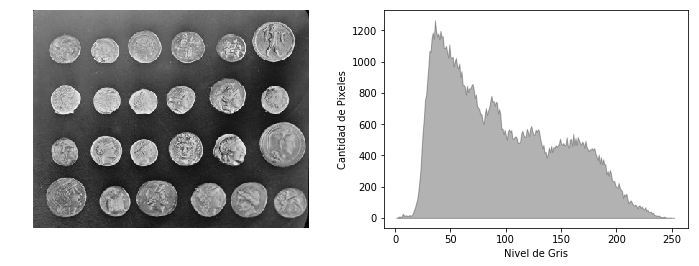

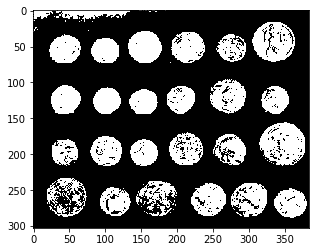

In [2]:
# Cargamos la imagen de prueba
img_2 = data.coins()
      
# Visualizamos la imagen de prueba y su histograma
skdemo.imshow_with_histogram(img_2)

# La umbralización consiste en simplmente comparar los píxeles de la imagen con el valor definido
img_BW = img_2 >= 128

plt.figure()
plt.imshow(img_BW)

Apesar de que las monedas parecieran ser más claras que el fondo, el histograma nos muestra que estás no tienen un nivel de intensidad que nos permitan separarlas fácilmente del fondo.

En este caso el uso de un método de umbralización simple no es adecuado.

## Segmentación por Umbral Adaptativo

Los métodos de umbralización adaptativos calculan de manera automática el umbral de acuerdo a la información contenida en la imagen. En consecuencia, cuando se tienen ambientes con condiciones de iluminación no adecuadas el umbral adaptativo obtiene mejores resultados que un método de umbralización simple. Existen diferentes métodos de umbralización de este tipo, entre ellos:

* Método Adaptativo Local
* método ISODATA
* Método Otsu
* Método de Yen
* Método de Li (basado en entreopía)

Veamos como usar los tres primeros y veamos los resultados en ambas imágenes:


In [ ]:
# Método Adaptativo

# Revise la documentación a fin de que conozca los parámetros de la función
t1 = filters.threshold_local(img_1, 15, 'mean')
t2 = filters.threshold_local(img_2, 81, 'gaussian')

img_BW_1 = img_1 > t1
img_BW_2 = img_2 > t2

skdemo.imshow_all(img_BW_1, img_BW_2, titles=["Arroz umbral Adaptativo - Mean", "Coins umbral Adaptativo - gaussian"])

In [ ]:
# Método ISODATA

# Revise la documentación a fin de que conozca los parámetros de la función
t1 = filters.threshold_isodata(img_1)
t2 = filters.threshold_isodata(img_2);

img_BW_1 = img_1 > t1;
img_BW_2 = img_2 > t2;

skdemo.imshow_all(img_BW_1, img_BW_2, titles=["Arroz umbral isodata", "Coins umbral isodata"])


In [ ]:
# Método otsu

# Revise la documentación a fin de que conozca los parámetros de la función
t1 = filters.threshold_yen(img_1)
t2 = filters.threshold_yen(img_2)

img_BW_1 = img_1 > t1;
img_BW_2 = img_2 > t2;

skdemo.imshow_all(img_BW_1, img_BW_2, titles=["Arroz umbral Yen", "Coins umbral Yen"])


Para efectos prácticos skiimage tiene una función que nos permite comparar los resultados de diferentes métodos de umbralización: isodata, li, mean, minimum, otsu, triangle, yen
    

In [ ]:
fig, ax = filters.try_all_threshold(img_1, figsize=(20, 20), verbose=False)

## Métodos de Extracción de Bordes

Como se explicó en la clase, estos métodos usan máscaras de convolución para obtener los bordes horizontales y verticales de una imagen, siendo las máscaras más usadas: Sobel, Prewitt y Roberts.

Veamos como usarlas: 


In [ ]:
# Filtro Sobel
gradiente = filters.sobel(img_1)
skdemo.imshow_all(img_1, gradiente)


Note que esta función integra tanto los bordes verticales como horizontales (calculando el gradiente), no obstante el resultado es una imagen en escala de grises que, específicamente, nos indica la probabilidad de que un píxel esté en el borde de un objeto. No obstante, para obtener los bordes de los objetos (imagen binaria) debemos umbralizar el gradiente. Por ejemplo:


In [ ]:
# Obtenga los bordes con un gradiente maypr a 0.1
img_bordes = gradiente > 0.1

skdemo.imshow_all(img_1, img_bordes)

Observe que este enfoque no es muy bueno ya que a pesar de que se obtienen los bordes de los objetos estos pueden contener ruido y además pueden ser gruesosm, cuando estos deben ser delgados y conectados.

Probemos las otras máscaras con la imagen de las monedas.

In [ ]:
# Filtro Sobel
g_sobel = filters.sobel(img_2)
g_scharr = filters.scharr(img_2)
g_prewitt = filters.prewitt(img_2)
g_roberts = filters.roberts(img_2)

skdemo.imshow_all(g_sobel > 0.1, g_scharr > 0.1, titles=["Sobel", "Scharr"])
skdemo.imshow_all(g_prewitt > 0.1, g_roberts > 0.1, titles=["Prewitt", "Roberts"])



## Detector de Bordes Canny

Canny es un detector de bordes que utiliza un filtro basado en la derivada de una gaussiana para calcular la intensidad de los gradientes. Es decir, se empeiza aplicando un filtro gaussiano que reduce el efecto del ruido presente en la imagen. Luego, se encuentran los posibles bordes en la imagen usando un filtro sobel, después los bordes potenciales se reducen a curvas de 1 píxel, eliminando aquellos píxeles que no tienen un máximo en la magnitud del gradiente (resultado del filtro sobel). Finalmente, los píxeles del borde se mantienen o se eliminan utilizando la histéresis.

En Skimage, Canny tiene tres parámetros ajustables: el desviación estándar del filtro gaussiano (cuanto más ruidosa es la imagen, mayor debe ser este parámetro), y el umbral minimo y máximo para la histéresis.

Veamos como usar el detector de bordes Canny:

In [ ]:
# Cargamos la imagen en escala de grises
img_3 = skimage.img_as_float(io.imread("imagenes/bicho.jpg"))
img_3 = color.rgb2gray(img_3)

# Aplicamos el detector de bordes Canny
# Revise la documentación para tener más información sobre los parámetros
img_3_bordes = feature.canny(img_3, sigma=1, low_threshold=0.2, high_threshold=0.5)

skdemo.imshow_all(img_3, img_3_bordes, titles=["Origial", "Bordes Canny"], size=8)


## Transformada de Hough

Las transformadas de Hough son una serie de algoritmos para detectar ciertos tipos de figuras geométricas en una imagen.  Al igual que con los detectores de bordes, las transformadas de Hough producen una imagen binaria que contiene el tipo de figura geométrica particular que se busca en la imagen.


### Transformada de Hought para líneas


In [ ]:
# Este tipo de transformada debe partir de una imagen con las líneas candidatas

#Aplicamos la transformada de Hough para líneas sobre los bordes de la imagen 3
lines = transform.probabilistic_hough_line(img_3_bordes, threshold=10, line_length=30, line_gap=1)

fig, axes = plt.subplots(1, 2, figsize=(20,5))
ax = axes.ravel()

ax[0].imshow(img_3_bordes)
ax[1].imshow(img_3)

for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_title('Líneas con Transformda de Hough')


### Transformada de Hough para Círculos

La transformada Hough en su forma más simple es un método para detectar líneas rectas, pero también se puede usar para detectar círculos o elipses. Este método es robusto contra el ruido o los puntos que faltan en el borde los círculos.

In [ ]:
from skimage import draw

# En este caso usamos la imagen de las monedas
img_2_bordes = feature.canny(img_2, sigma=3, low_threshold=10, high_threshold=50)

# Detecte círculos de diferentes radios radios
hough_radii = np.arange(10, 40, 2)
hough_res = transform.hough_circle(img_2_bordes, hough_radii)

# Seleccione the 24 círculos más prominentes
accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=40)

# Se pintan los círculos en la imagen
image = color.gray2rgb(img_2)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = draw.circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

skdemo.imshow_all(img_2_bordes, image, size=8)

## Métodos de Segmentación basados en Regiones

Una región consiste en una parte de la imagen que satisface un cierto criterio de uniformidad. Así, la segmentación por regiones considera que cada región se forma a partir de píxeles considerados semillas  y  evoluciona,  mediante  un 
algoritmo recursivo, incorporando aquellos píxeles vecinos que satisfacen una condición establecida. Comúnmente, los criterios utilizados se refieren a propiedades de proximidad y homogeneidad. El proceso de segmentación finaliza cuando 
no se encuentran más píxeles que cumplan la condición especificada.

Como vimos en clase, existen diferentes métodos de segmentación basada en regiones, a continuación, vamos a usar algunos de ellos usando Skimage.


### Segmentación por Watershed

El nombre de watershed proviene de una analogía con la hidrología. El uso de este método de segmentación consiste en "inundar" una imagen para determinar los puntos en los que se unen las cuencas, las cuales se determinan a partir de ciertos marcadores. Las líneas que separan las cuencas hidrográficas corresponden a la segmentación de la imagen.

En este sentido, el mapa de elevación incial es fundamental para una buena segmentación. Por ejemplo, para el problema de las monedas, la amplitud del gradiente proporciona un buen mapa de elevación inicial. 

Usamos el operador Sobel para calcular la amplitud del gradiente:

Tipo de dato d:  float64


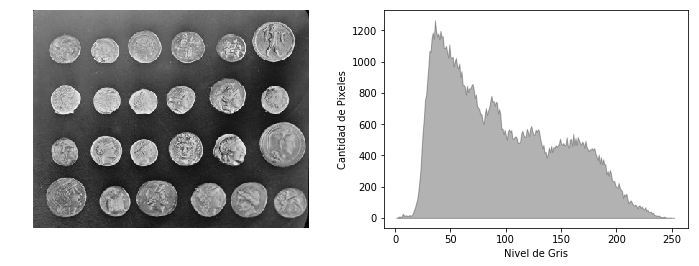

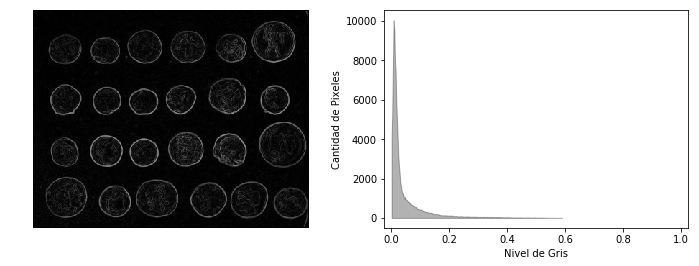

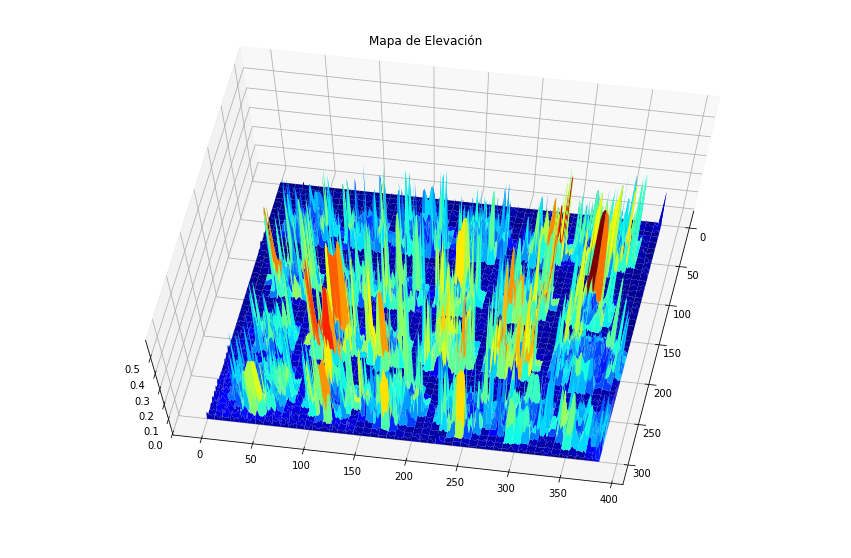

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Volvemos a calcular el gradiente de la imagen usando el operador sobel
skdemo.imshow_with_histogram(img_2)
img_2_bordes = filters.sobel(img_2)
skdemo.imshow_with_histogram(img_2_bordes)
print ("Tipo de dato d: ", img_2_bordes.dtype)
# Visualizamos el mapa de elevacion, es decir el gradiente como una imagen 3D
xx, yy = np.mgrid[0:img_2_bordes.shape[0], 0:img_2_bordes.shape[1]]
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img_2_bordes, cmap="jet")
ax.view_init(70, 10)
ax.set_title("Mapa de Elevación")
plt.show()

In [ ]:
# Creamos los marcadores que serán usados para inundar el mapa de elevación
markers = np.zeros_like(img_2)
markers[img_2 < 30] = 1
markers[img_2 > 150] = 2
print ("Tipo de dato d: ", markers.dtype)

# Aplicamos el método de segmentación
segmentation = morphology.watershed(img_2_bordes, markers)

#Etiquetamos las regiones y las mostramos
etiqeutas = measure.label(segmentation)
plt.imshow(etiqeutas, cmap="jet")
# plt.imshow(segmentation)


## Entregables de la Práctica

Uno de los puntos neurálgicos en los sistemas de visión artificial es la segmentación de los objetos de interés en la imagen. Una mala selección de un método segmentación hará que las etapas de descripción y reconocimiento sean más o menos eficientes para la clasificación de los objetos. El objetivo de esta práctica es experimentar con los diferentes métodos de segmentación vistos en clase y presentados en las secciones anteriores. La idea es ANALIZAR cuál o cuáles de los métodos son los más adecuados para segmentar y contar los objetos de interés en las imágenes siguientes.

* Aplique cada uno de los métodos presentados a cada imagen. Evalúe si algún canal en alguno de los espacios de color es adecuado para mejorar los resultados de la segmentación. Si el método requiere que usted fije algún parámetro, EXPLIQUE como hizo la selección del valor del mismo.
* Para los métodos basados en derivadas use las tres máscaras posibles: Sobel, Prewitt y Roberts y compare entre los resultados obtenidos un filtro LoG y con la aplicación de un máximo entre las máscaras en X e Y de dichos filtros. Qué diferencias hay? Ha qué se deben esas diferencias?
* Una vez seleccione el mejor método de segmentación para cada imagen, aplique el método de detección de componentes conexas (método label del paquete measure) y coloréelas (use un mapa de color, por ejemplo, el "jet"). Por qué no funciona en cada una de las imágenes dadas?
* Seleccione y justifique su selección de uno de los métodos de segmentación para cada una de las imágenes.

Las imagenes sobre las que se deben aplicar los métodos de segmentación son:
* Pera
* SemillasDacusCarota
* U4-3


<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h1>**Integrantes:**</h1></span> 
    <ul>
        <li>Camilo Vahos</li>
        <li>Julian Herrera</li>
    </ul>
</div>

In [ ]:
# Inicie aquí el desarrollo de la práctica
# Siempre que usemos matplotlib en Jupyter es necesario poner esta línea antes de cualquier otra
%matplotlib inline

# Importamos las bibliotecas necesarias y les asigamos un alias
import skimage                           # Biblioteca para la manipulación de imágenes
import numpy as np                       # Biblioteca para la manipulación de matrices

# Importamos algunos paquetes específicos
from matplotlib import pyplot as plt     # Biblioteca para crear graficas y mostrar las imágenes en pantalla

from skimage import data                 # Paquete con imágenes de prueba
from skimage import io                   # Paquete para lectura/escritura de imágenes
from skimage import color                # Paquete con las operaciones de transformaciones entre espacios de color
from skimage import exposure             # Paquete con las funciones para calcular y alterar el histograma
from skimage import filters              # Paquete que contiene las máscaras y filtros de suavizado y realzado
from skimage import util                 # Paquete que contiene las funciones para cambiar el tipo de dato de las imágenes

from scipy import ndimage                # Usamos esta biblioteca para realizar la operación de convolución

import skdemo                            # Paquete ESPECIAL ADJUNTO con algunas funciones extra de visualización

##################

from skimage import morphology           # Para crear el kernel de convolución en los filtros no lienales
from skimage import transform            # Esta biblioteca es la que contiene la implementación de Hough
from skimage import measure              # Esta biblioteca contiene el método de etiquetado de regiones
from skimage import feature              # Esta biblioteca es la que contiene la implementación del canny

# Con este nos aseguramos que las imagenes en niveles de gris, se vean como tal siempre.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'


In [ ]:
img_pera = io.imread("imagenes/Pera.jpg")
img_semilla = io.imread("imagenes/SemillasDacusCarota.png")
img_semilla = img_semilla[:,:,:3]
img_U4 = io.imread("imagenes/U4-3.png")

# Empezamos por conocer los tipos de imagenes con que vamos a trabajar
# y las dimensiones de c/u para conocer el tamaño o muestreo con vamos a trabajar
print ("Tipo de dato img Pera: ", img_pera.dtype)
print(img_pera.shape)

print ("Tipo de dato img semillas: ", img_semilla.dtype)
print(img_semilla.shape)

print ("Tipo de dato img concreto: ", img_U4.dtype)
print(img_U4.shape)


# Evaluacion en los espacios de color
skdemo.imshow_all(img_pera,img_semilla,img_U4, titles=["pera","Semillas","U4-3"])

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h3>**Importante:**</h3></span> Segun lo aprendido en el curso, nos parece importante partir del analisis de los histogramas de cada imagen y asi poder determinar una solucion optima para la segmentacion de los objetos de interes. </div>
    

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h1>**ESPACIOS DE COLOR:**</h1></span> 

In [ ]:
##Analisis de histogramas
skdemo.imshow_with_histogram(img_pera)
skdemo.imshow_with_histogram(img_semilla)
skdemo.imshow_with_histogram(img_U4)

In [ ]:
# Conversion de las imagenes a escalas de grises
pera_in_gray = color.rgb2gray(img_pera.copy())
semilla_in_gray = color.rgb2gray(img_semilla.copy())
U4_in_gray = color.rgb2gray(img_U4.copy())

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:black"><h3>:) => CANAL HSV:</h3></span> 
</div>

In [ ]:
# 
pera_hsv = color.rgb2hsv(img_pera.copy())
skdemo.imshow_with_histogram(pera_hsv)

# debido al analisis que hacemos en la imagen en hsv

skdemo.imshow_with_histogram(pera_hsv[:,:,1])
pera_canal_s = pera_hsv[:,:,1] >= 0.2

semilla_hsv = color.rgb2hsv(img_semilla.copy())
skdemo.imshow_with_histogram(semilla_hsv)
skdemo.imshow_with_histogram(semilla_hsv[:,:,1])
semilla_canal_s = semilla_hsv[:,:,1] >= 0.5

# No es muy eficiente por la manera como se ve el histograma
U4_hsv = color.rgb2hsv(img_U4.copy())
skdemo.imshow_with_histogram(U4_hsv)
skdemo.imshow_with_histogram(U4_hsv[:,:,2])
U4_canal_v = U4_hsv[:,:,1] >= 0.4

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h3>******* Analisis HSV:</h3></span> 
    <ol>
         <li> Observamos que en la pera el canal de saturacion nos puede servir para aislar objetos para cuantizacion esto lo detectamos en el analisis del histograma donde se evidencia que la saturacion me puede permitir aislar completamente el objeto de interes.  </li>
         <li>En las semillas podemos decir que no es adecuado usar el canal de saturacion ya que hace que los objetos se mezclen y que en fases posteriores se traten como uno solo varios elementos. Para hacer una cuantizacion de estas seria ideal solo trabajar con el nucleo de las semillas y no con elementos que salen de ellas, en posteriores analisis quiza encontremos otra manera de solucionar esto.</li>
         <li>En la imagen del concreto segun los analisis del histograma vemos que con el brillo de la imagen en HSV podemos trabajar para determinar niveles de profundidad de los poros tomando como referencia la intensidad de los grises.</li>
    </ol>
    <h1> :( Canales Yiq</h1>
</div>

In [ ]:
# No conviene usar este espacio de color YIQ en este tipo de problemas 
# para segmentar los elementos de importancia
pera_yiq = np.clip(color.rgb2yiq(img_pera),0,1)
skdemo.imshow_with_histogram(util.img_as_float(pera_yiq))

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>********CANALES RGB:</h1></span>
</div>

In [ ]:

skdemo.imshow_with_histogram(img_pera.copy())
skdemo.imshow_with_histogram(img_pera.copy()[:,:,1])
pera = img_pera.copy()[:,:,1] >= 68 # este parametro lo damos en base al analisis de hist 
                                    # debido a la uniformidad del background y/o acumulacion de gris
                                    # y predominancia del canal verde en la imagen.
                                    # da cabida a aislar facilmente el objeto dando como salida los valores 
                                    # mayores o iguales a la acumulacion de gris oscuro.

test_green_channel_seg = np.clip(pera.copy(),0,1)
skdemo.imshow_with_histogram(test_green_channel_seg)


In [ ]:
skdemo.imshow_with_histogram(img_semilla.copy())
skdemo.imshow_with_histogram(img_semilla.copy()[:,:,0])
semilla = img_semilla.copy()[:,:,0] >= 10

skdemo.imshow_with_histogram(img_U4.copy())
skdemo.imshow_with_histogram(img_U4.copy()[:,:,0])
U4 = img_U4.copy()[:,:,0] <= 120

test_first_channel = np.clip(U4.copy(),0,1)
skdemo.imshow_with_histogram(test_first_channel)

<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h3>*******Analisis imagen del concreto:</h3></span> En la imagen del concreto podemos segmentar los poros dando como salida los valores menos a 120 como se evidencia en el histograma, se debe tener presente que si lo que se busca es evaluar la profundidad de los poros esta no seria la observacion adecuada, pero para cuantizacion y/o de los elementos con mas amplitud puede ser adecuado.  </div>

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>****CANALES XYZ:</h1></span>
</div>

In [ ]:
pera_xyz = color.rgb2xyz(img_pera.copy())
# print ("Tipo de dato d: ", pera_xyz.dtype)
skdemo.imshow_with_histogram(pera_xyz)
skdemo.imshow_with_histogram(pera_xyz[:,:,1])
peraCAnal_y = pera_xyz.copy()[:,:,1] >= 0.1

semilla_xyz = np.clip(color.rgb2xyz(img_semilla.copy()),0,1)
# print ("Tipo de dato d: ", pera_xyz.dtype)
skdemo.imshow_with_histogram(semilla_xyz)
skdemo.imshow_with_histogram(semilla_xyz[:,:,2])
semillaCAnal_y = semilla_xyz.copy()[:,:,1] >= 0.1

U4_xyz = np.clip(color.rgb2xyz(img_U4.copy()),0,1)
# print ("Tipo de dato d: ", pera_xyz.dtype)
skdemo.imshow_with_histogram(U4_xyz)
skdemo.imshow_with_histogram(U4_xyz[:,:,2])
U4CAnal_y = U4_xyz.copy()[:,:,1] >= 0.2

param_channels_img = [pera_canal_s,semilla_canal_s,U4_canal_v]
param_channels_y = [peraCAnal_y,semillaCAnal_y,U4CAnal_y]
segments_by_channels = [pera,semilla,U4]

f, plots = plt.subplots(3, 3, figsize=(10, 12))#ancho,alto
for (plts,hsv,xyz,rgb) in zip(plots,param_channels_img, param_channels_y ,segments_by_channels):
    plts[0].imshow(hsv)
    plts[0].set_title('hsv',fontsize=16)
    plts[1].imshow(xyz)
    plts[1].set_title('xyz',fontsize=16)
    plts[2].imshow(rgb)
    plts[2].set_title('rgb',fontsize=16)     

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>********Metodo Adaptativo:</h1></span>
</div>

In [ ]:
# Aplicamos filtros mediana a cada imagen
pera_mean = filters.threshold_local(pera_in_gray.copy(), 1199, 'mean')
semilla_mean = filters.threshold_local(semilla_in_gray.copy(), 15, 'mean')
U4_mean = filters.threshold_local(U4_in_gray.copy(), 1179, 'mean')

pera_mean_ = pera_in_gray > pera_mean
semilla_mean_ = semilla_in_gray > semilla_mean
U4_mean_ = U4_in_gray > U4_mean

# Aplicamos filtros gaussian a cada imagen
pera_gaussian = filters.threshold_local(pera_in_gray.copy(), 2099, 'mean')
semilla_gaussian = filters.threshold_local(semilla_in_gray.copy(), 15, 'mean')
U4_gaussian = filters.threshold_local(U4_in_gray.copy(), 1179, 'mean')

pera_gaussian_ = pera_in_gray > pera_gaussian
semilla_gaussian_ = semilla_in_gray > semilla_gaussian
U4_gaussian_ = U4_in_gray > U4_gaussian

# Aplicamos filtros promedios y usamos una mascar de 3x3
pera_promedio = filters.rank.mean(pera_in_gray.copy(), np.ones((3,3)))
semilla_promedio = filters.rank.mean(semilla_in_gray.copy(), np.ones((3,3)))
U4_promedio = filters.rank.mean(U4_in_gray.copy(), np.ones((3,3)))

# Parametrizacion parametrizar visualizacion de img
original_param = [img_pera, img_semilla, img_U4]
mean_like_param = [pera_mean_, semilla_mean_, U4_mean_]
gaussian_like_param = [pera_gaussian_, semilla_gaussian_, U4_gaussian_]
promedio_like_param = [pera_promedio, semilla_promedio, U4_promedio]

f, plots = plt.subplots(3, 4, figsize=(20, 17))#ancho,alto
for (plts,original, mean, gaussian, promedio) in zip(plots, original_param, mean_like_param, gaussian_like_param, promedio_like_param):
    plts[0].imshow(original)
    plts[0].set_title('Original',fontsize=16)
    plts[1].imshow(mean)
    plts[1].set_title('Mean',fontsize=16) #para este tipo de filtro obtenemos mucho ruido
    plts[2].imshow(gaussian)
    plts[2].set_title('Gaussian',fontsize=16)
    plts[3].imshow(promedio)
    plts[3].set_title('Promedio',fontsize=16)


<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
<span style="color:#4BACC6" ><h3>********Analisis y comparacion de resultados:</h3></span> En la aplicacion de los filtros de paso bajo observamos que el filtro mean genera mucho ruido en la imagen de las semillas y la del concreto, lo que puede derivar en problemas para la segmentacion de los elementos de importancia, mientras que en la img de la pera podemos observar que se obtiene un resultado mejor, debido a el espacio y distribucion de color  de dicha imagen.</span>
<br/>
<h1> Metodo ISODATA</h1>


In [ ]:
pera_Isodata = filters.threshold_isodata(pera_in_gray.copy())
semilla_Isodata = filters.threshold_isodata(semilla_in_gray.copy());
U4_Isodata = filters.threshold_isodata(U4_in_gray.copy());

peraIsodata = pera_in_gray > pera_Isodata;
semillaIsodata = semilla_in_gray > semilla_Isodata;
U4Isodata = U4_in_gray > U4_Isodata;

f, plots = plt.subplots(3, 2, figsize=(20, 17))#ancho,alto
for (plts,original,isodata) in zip(plots,[img_pera,img_semilla,img_U4],[peraIsodata,semillaIsodata,U4Isodata]):
     plts[0].imshow(original)
     plts[0].set_title('Original',fontsize=16)
     plts[1].imshow(isodata)
     plts[1].set_title('Isodata',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Método otsu:</h1></span>
</div>

In [ ]:

pera_otsu = filters.threshold_yen(pera_in_gray)
semilla_otsu = filters.threshold_yen(semilla_in_gray)
U4_otsu = filters.threshold_yen(U4_in_gray)


peraOtsu = pera_in_gray > pera_otsu;
semillaOtsu = semilla_in_gray > semilla_otsu;
U4Otsu = U4_in_gray > U4_otsu;

f, plots = plt.subplots(3, 2, figsize=(20, 17))#ancho,alto
for (plts,original,otsu) in zip(plots,[img_pera,img_semilla,img_U4],[peraOtsu,semillaOtsu,U4Otsu]):
     plts[0].imshow(original)
     plts[0].set_title('Original',fontsize=16)
     plts[1].imshow(otsu)
     plts[1].set_title('Otsu',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Metodo de comparacion:</h1></span>
</div>

In [ ]:
fig, ax = filters.try_all_threshold(pera_in_gray.copy(), figsize=(20, 20), verbose=False)
fig, ax = filters.try_all_threshold(semilla_in_gray.copy(), figsize=(20, 20), verbose=False)
fig, ax = filters.try_all_threshold(U4_in_gray.copy(), figsize=(20, 20), verbose=False)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>********Métodos de Extracción de Bordes:</h1></span>
</div>

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Filtro Sobel:</h1></span>
</div>

In [ ]:

gradiente_pera = filters.sobel(pera_in_gray.copy())
gradiente_semilla = filters.sobel(semilla_in_gray.copy())
gradiente_U4 = filters.sobel(U4_in_gray.copy())

# Visualizamos los histogramas
skdemo.imshow_with_histogram(gradiente_pera)
skdemo.imshow_with_histogram(gradiente_semilla)
skdemo.imshow_with_histogram(gradiente_U4)

#Los umbralizamos
#los valores para umbralizar se toman de los respectivos histogramas para generar la mejor imagen
bordes_pera = gradiente_pera > 0.02
bordes_semilla = gradiente_semilla >0.08
bordes_U4 = gradiente_U4 > 0.05

f, plots = plt.subplots(3, 3, figsize=(20, 17))#ancho,alto
for (plts,grays,sobel, gradiente) in zip(plots,[pera_in_gray,pera_in_gray,U4_in_gray], [gradiente_pera,gradiente_semilla,gradiente_U4],[bordes_pera, bordes_semilla, bordes_U4]):
     plts[0].imshow(grays)
     plts[0].set_title('Gray',fontsize=16)
     plts[1].imshow(sobel)
     plts[1].set_title('Sobel',fontsize=16)
     plts[2].imshow(gradiente)
     plts[2].set_title('Con gradiente',fontsize=16)
# skdemo.imshow_all(peraToGray.copy(), gradiente)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Filtro Scharr:</h1></span>
</div>

In [ ]:
scharr_pera = filters.scharr(pera_in_gray.copy())
scharr_semilla = filters.scharr(semilla_in_gray.copy())
scharr_U4 = filters.scharr(U4_in_gray.copy())

# Visualizamos los histogramas
skdemo.imshow_with_histogram(scharr_pera)
skdemo.imshow_with_histogram(scharr_semilla)
skdemo.imshow_with_histogram(scharr_U4)

#Los umbralizamos
#los valores para umbralizar se toman de los respectivos histogramas para generar la mejor imagen con sus bordes
scharrpera = scharr_pera > 0.02
scharrsemilla = scharr_semilla > 0.06
scharrU4 = scharr_U4 > 0.05



f, plots = plt.subplots(3, 3, figsize=(20, 17))
for (plts,gray,scharr,bordes) in zip(plots,[pera_in_gray,semilla_in_gray,U4_in_gray],[scharr_pera,scharr_semilla,scharr_U4],[scharrpera,scharrsemilla, scharrU4 ]):
     plts[0].imshow(gray)
     plts[0].set_title('gray',fontsize=16)
     plts[1].imshow(scharr)
     plts[1].set_title('scharr',fontsize=16)
     plts[2].imshow(bordes)
     plts[2].set_title('Bordes',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Filtro prewitt:</h1></span>
</div>

In [ ]:

prewitt_pera = filters.prewitt(pera_in_gray.copy())
prewitt_semilla = filters.prewitt(semilla_in_gray.copy())
prewitt_U4 = filters.prewitt(U4_in_gray.copy())

# Visualizamos los histogramas
skdemo.imshow_with_histogram(prewitt_pera)
skdemo.imshow_with_histogram(prewitt_semilla)
skdemo.imshow_with_histogram(prewitt_U4)

#Los umbralizamos
#los valores para umbralizar se toman de los respectivos histogramas para generar la mejor imagen con sus bordes
prewittpera = prewitt_pera > 0.02
prewittsemilla = prewitt_semilla > 0.06
prewittU4 = prewitt_U4 > 0.05



f, plots = plt.subplots(3, 3, figsize=(20, 17))
for (plts,gray,prewitt,bordes) in zip(plots,[pera_in_gray,semilla_in_gray,U4_in_gray],[prewitt_pera,prewitt_semilla,prewitt_U4],[prewittpera,prewittsemilla, prewittU4 ]):
     plts[0].imshow(gray)
     plts[0].set_title('gray',fontsize=16)
     plts[1].imshow(prewitt)
     plts[1].set_title('prewitt',fontsize=16)
     plts[2].imshow(bordes)
     plts[2].set_title('Bordes',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Filtro roberts:</h1></span>
</div>

In [ ]:

roberts_pera = filters.roberts(pera_in_gray.copy())
roberts_semilla = filters.roberts(semilla_in_gray.copy())
roberts_U4 = filters.roberts(U4_in_gray.copy())

# Visualizamos los histogramas
skdemo.imshow_with_histogram(roberts_pera)
skdemo.imshow_with_histogram(roberts_semilla)
skdemo.imshow_with_histogram(roberts_U4)

#Los umbralizamos
#los valores para umbralizar se toman de los respectivos histogramas para generar la mejor imagen con sus bordes
robertspera = roberts_pera > 0.02
robertssemilla = roberts_semilla > 0.06
robertsU4 = roberts_U4 > 0.04



f, plots = plt.subplots(3, 3, figsize=(20, 17))
for (plts,gray,roberts,bordes) in zip(plots,[pera_in_gray,semilla_in_gray,U4_in_gray],[roberts_pera,roberts_semilla,roberts_U4],[robertspera,robertssemilla, robertsU4 ]):
     plts[0].imshow(gray)
     plts[0].set_title('gray',fontsize=16)
     plts[1].imshow(roberts)
     plts[1].set_title('roberts',fontsize=16)
     plts[2].imshow(bordes)
     plts[2].set_title('Bordes',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Detector de bordes canny:</h1></span>
</div>

In [ ]:
# Detector de Bordes Canny
pera_Canny = feature.canny(pera_in_gray.copy(), sigma=1, low_threshold=0.2, high_threshold=0.5)
semilla_Canny = feature.canny(semilla_in_gray.copy(), sigma=1, low_threshold=0.2, high_threshold=0.5)
U4_Canny = feature.canny(U4_in_gray.copy(), sigma=1, low_threshold=0.2, high_threshold=0.1)

original = [pera_in_gray, semilla_in_gray, U4_in_gray]
canny = [pera_Canny, semilla_Canny, U4_Canny]

f, plots = plt.subplots(3, 2, figsize=(20, 17))
for (plts,original,canny) in zip(plots,original,canny):
    plts[0].imshow(original)
    plts[0].set_title('original',fontsize=16)
    plts[1].imshow(canny)
    plts[1].set_title('canny',fontsize=16)
    

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Filtro LoG:</h1></span>
</div>

In [ ]:
pera_gauss = filters.gaussian(pera_in_gray.copy(), sigma=1.0)
pera_LoG = filters.laplace(pera_gauss)
semilla_gauss = filters.gaussian(semilla_in_gray.copy(), sigma=1.0)
semilla_LoG = filters.laplace(semilla_gauss)
U4_gauss = filters.gaussian(U4_in_gray.copy(), sigma=1.0)
U4_LoG = filters.laplace(U4_gauss)

# Obtenemos los respectivos histogramas para estimar el valor que usaremos en la umbralización
skdemo.imshow_with_histogram(pera_LoG)
skdemo.imshow_with_histogram(semilla_LoG)
skdemo.imshow_with_histogram(U4_LoG)


peraUmbral = pera_LoG >= 0.007
semillaUmbral = semilla_LoG >= 0.02
U4Umbral = U4_LoG >= 0.01


sobel = [bordes_pera,bordes_semilla,bordes_U4]
scharr = [scharrpera,scharrsemilla,scharrU4]
prewitt = [prewittpera,prewittsemilla,prewittU4]
roberts = [robertspera,robertssemilla,robertsU4]
LoG = [peraUmbral,semillaUmbral,U4Umbral]

f, plots = plt.subplots(3, 5, figsize=(20, 17))
for (plts,sobel,scharr,prewitt,roberts,log) in zip(plots,sobel,scharr,prewitt,roberts, LoG):
    plts[0].imshow(sobel)
    plts[0].set_title('sobel',fontsize=16)
    plts[1].imshow(scharr)
    plts[1].set_title('scharr',fontsize=16)
    plts[2].imshow(prewitt)
    plts[2].set_title('prewitt',fontsize=16)
    plts[3].imshow(roberts)
    plts[3].set_title('roberts',fontsize=16)
    plts[4].imshow(log)
    plts[4].set_title('LoG',fontsize=16)

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>==> Maximo:</h1></span>
</div>

In [ ]:

k = morphology.square(3)

pera_sobel_max = filters.rank.maximum(bordes_pera, k)
semilla_sobel_max = filters.rank.maximum(bordes_semilla, k)
U4_sobel_max = filters.rank.maximum(bordes_U4, k)

pera_scharr_max = filters.rank.maximum(scharrpera, k)
semilla_scharr_max = filters.rank.maximum(scharrsemilla, k)
U4_scharr_max = filters.rank.maximum(scharrU4, k)

pera_prewitt_max = filters.rank.maximum(prewittpera, k)
semilla_prewitt_max = filters.rank.maximum(prewittsemilla, k)
U4_prewitt_max = filters.rank.maximum(prewittU4, k)

pera_roberts_max = filters.rank.maximum(prewittpera, k)
semilla_roberts_max = filters.rank.maximum(prewittsemilla, k)
U4_roberts_max = filters.rank.maximum(prewittU4, k)

sobel_max=[pera_sobel_max,semilla_sobel_max,U4_sobel_max]
scharr_max =[pera_scharr_max,semilla_scharr_max,U4_scharr_max]
prewitt_max=[pera_prewitt_max,semilla_prewitt_max,U4_prewitt_max]
roberts_max=[pera_roberts_max,semilla_roberts_max,U4_roberts_max]

sobel = [bordes_pera,bordes_semilla,bordes_U4]
scharr = [scharrpera,scharrsemilla,scharrU4]
prewitt = [prewittpera,prewittsemilla,prewittU4]
roberts = [robertspera,robertssemilla,robertsU4]
LoG = [peraUmbral,semillaUmbral,U4Umbral]

f, plots = plt.subplots(3, 2, figsize=(20, 17))
for (plts,sobel,sobelmax) in zip(plots,sobel,sobel_max):
    plts[0].imshow(sobel)
    plts[0].set_title('sobel',fontsize=16)
    plts[1].imshow(sobelmax)
    plts[1].set_title('sobel max',fontsize=16)
    
f, plots = plt.subplots(3, 2, figsize=(20, 17))
for (plts,scharr,schmax) in zip(plots,scharr,scharr_max):
    plts[0].imshow(scharr)
    plts[0].set_title('scharr',fontsize=16)
    plts[1].imshow(schmax)
    plts[1].set_title('scharr max',fontsize=16)
    
f, plots = plt.subplots(3, 2, figsize=(20, 17))
for (plts,prewitt,premax) in zip(plots,prewitt,prewitt_max):
    plts[0].imshow(prewitt)
    plts[0].set_title('pewitt',fontsize=16)
    plts[1].imshow(premax)
    plts[1].set_title('pewitt max',fontsize=16)
    
f, plots = plt.subplots(3, 2, figsize=(20, 17))
for (plts,roberts,romax) in zip(plots,roberts,roberts_max):
    plts[0].imshow(roberts)
    plts[0].set_title('roberts',fontsize=16)
    plts[1].imshow(romax)
    plts[1].set_title('roberts max',fontsize=16)




<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h1>******* Segmentacion basada en regiones:</h1></span> 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Métodos de Segmentación basados en Regiones - Mapa de elevación

img_pera = io.imread("imagenes/Pera.jpg")
pera_in_hsv_test = color.rgb2hsv(img_pera.copy())
skdemo.imshow_with_histogram(pera_in_hsv_test)

pera_hsv_s = pera_in_hsv_test[:,:,1]
skdemo.imshow_with_histogram(pera )
#visualizamos histograma de la imagen escogida para hacer la inundacion
skdemo.imshow_with_histogram(util.img_as_ubyte(pera_hsv_s))
# CANAL HSV

pera_channel_s = filters.sobel(util.img_as_ubyte(pera_hsv_s) )

xx, yy = np.mgrid[0:pera_channel_s.shape[0], 0:pera_channel_s.shape[1]]
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, pera_channel_s, cmap="viridis")
ax.view_init(70, 10)
ax.set_title("Mapa de Elevación")
plt.show()

#Analisis para la imagen de la pera
markers_p = np.zeros_like(util.img_as_ubyte(pera_hsv_s))
markers_p[pera_hsv_s <= 0.1] = 1   #no tiene mucho sentido hacer la inundacion en estos valores de la imagen
markers_p[pera_hsv_s > 28] = 2     #ya que son los colores de background en la imagen

segmentation_p = morphology.watershed(pera_hsv_s, markers_p)
etiquetas_p = measure.label(segmentation_p)
plt.imshow(etiquetas_p, cmap="viridis")

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>Analisis segmentacion de la pera:</h1></span>
    <p> Para realizar este metodo de segmentacion se escogieron los dos resultados que vimos que nos servia para segmentar el onjeto de interes (La pera)</p>
    <ul>
        <li>imagen en el canal verde.</li>
        <li>imagen en el canal de saturacion</li>
    </ul>
    <p>Por obvias razones como se puede ver en las imagenes con sus histogramas se ve que puede servir para segmentar varias peras en caso que estuvieran en la imagen, pero al analizar el histograma no vemos las condiciones en ninguno de los dos histogramas, para lograr la inundacion de la imagen, ademas la unica parte donde se visualizan las cuencas corresponden al background de la imagen, tambien podemos observar que el mapa de elevacion no favorece para hacer este tipo de procedimiento, la amplitud del gradiente es minima</p>
    <h2>Ademas para esta imagen consideramos que no es importante inundar y colorear, ya que por deduccion creemos que este procedimiento se hace mas que todo para etiquetar varios objetos y segmentarlos, lo que se logro en esta imagen solo analizando y manipulando sus espacios de color.</h2>
</div>


In [ ]:
print ("Tipo de dato {} semilla_in_gray variable".format(semilla_in_gray.dtype) )
semilla_region = filters.sobel(semilla_in_gray.copy())
# img_to_try = color.rgb2gray(util.img_as_float(img_eye))
print ("Tipo de dato {} semilla_region variable".format(semilla_region.dtype) )


skdemo.imshow_with_histogram(semilla_in_gray)
skdemo.imshow_with_histogram(semilla_region)

xx, yy = np.mgrid[0:semilla_region.shape[0], 0:semilla_region.shape[1]]
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, semilla_region, cmap="inferno")
ax.view_init(70, 10)
ax.set_title("Mapa de Elevación")
plt.show()

markers_s = np.zeros_like(semilla_in_gray)
#markers_s[semilla_in_gray < 30] = 1
#markers_s[semilla_in_gray > 150] = 2
#print ("Tipo de dato d: ", markers_s.dtype)
#
#segmentation_s = morphology.watershed(semilla_region, markers_s)
#
#etiquetas_s = measure.label(segmentation_s)
#plt.imshow(etiquetas_s, cmap="inferno")

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>Analisis segmentacion de las semillas:</h1></span>
  
<p>De nuevo al analizar el histograma no vemos las condiciones en ninguno de los dos histogramas, para lograr la inundacion de la imagen, ademas, como no hay cuencas no se pueden determinar las líneas que separan las mismas las cuales corresponderian a la segmentación de la imagen dado el caso.</p>
</div>

In [ ]:
print ('''Tipo de dato {0} img_U4 y las dimensiones {1} 
variable'''.format(img_U4.copy()[:,:,0].dtype, img_U4.copy()[:,:,0].shape) )

img_U4_final = img_U4.copy()[:,:,0]
img_U4_edges = filters.sobel(util.img_as_ubyte(img_U4.copy()[:,:,0]) )

print ("Tipo de dato {} img_U4_region variable".format(img_U4_edges.dtype) )

skdemo.imshow_with_histogram(img_U4_final)
skdemo.imshow_with_histogram(img_U4_edges)

xx, yy = np.mgrid[0:img_U4_edges.shape[0], 0:img_U4_edges.shape[1]]
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img_U4_edges, cmap="rainbow")
ax.view_init(70, 10)
ax.set_title("Mapa de Elevación")
plt.show()

markers_c = np.zeros_like(img_U4_final)
markers_c[img_U4_edges < 140] = 1
markers_c[img_U4_edges > 170] = 2
print ("Tipo de dato d: ", markers_c.dtype)

segmentation_c = morphology.watershed(img_U4_edges, markers_c)

etiquetas_s = measure.label(segmentation_c)
plt.imshow(etiquetas_s, cmap="rainbow")

<div style="padding:10px; border-radius:10px; border:2px solid #4BACC6; background:#EEEEEE">
    <span style="color:#4BACC6" ><h1>Analisis segmentacion de los poros del concreto:</h1></span>
  
<p>Al analizar el histograma de la imagen seleccionada para la segmentacion
vemos que hay unas pequeñas cuencas en el rango que programamos, mas sin embargo, deducimos que como el watershed 
cuando aplica las propiedades de proximidad encuentra las lineas que separan las cuencas muy cercanas no logra hacer una 
adecuada segmentacion debido a la inclinacion y cambios minimos entre pixeles vecinos.</p>
</div>


<div style="padding:10px; border-radius:10px; border:2px solid #A43D39; background:#EEEEEE">
<span style="color:#A43D39"><h3>******* Conclusiones y experiencias:</h3></span> 
    <ul>
         <li> Cuando se realiza la evaluacion de la umbralizacion en los diferentes espacios de color se encuentra que el RGB, especialmente en el canal G. Dejando la segmentacion de la pera en un buen nivel, otro espacio de color que genero muy buenos resultados fue el hsv en el canal de saturacion.</li>
         <li>Para la umbralizacion se usaron sus respectivos histogramas, ya que estos ayudan a entender mas detalladamente donde se encuentran los objetos de interes y asi determinar el valor para la umbralizacion.</li>
         <li>Se puede notar que el LoG no es muy eficiente en estos casos pues genera aun mas ruido del que ya tienen las imagenes.</li>
        <li>Cuando se aplica el maximo a la imagen de las semillas genera un mejor resultado en la segmentacion, debido a que las partes externas de estas tienden a confundirse con el ruido de la imagen, al aplicar el maximo se logran segmentar estos objetos de interes</li>
    </ul>
</div>